In [69]:
#pip install ip2geotools
#pip install ipinfo
#conda install -c anaconda basemap

# select network
TOPAZ = ("topaz","f071c66c")
SCHLESI = ("schlesi","9925efd6")
NETWORK,FORK_DIGEST=TOPAZ

# run crawler
#!sh crawl-network.sh $NETWORK 50 snapshot

#tail -n+2 ~/.topaz/crawler* | grep f071c66c | sed 's/\".*\"//g' |  cut -d',' -f3,12,14 | sort -t ',' -k1,1 -k2,2nr -s -u | sort -t ',' -u -k1,1 | cut -d',' -f3 |sed -e "s/^enr://" | wc -l

In [70]:
import pandas as pd 



dfs = []
start = 12000
numFiles = !ls -l ~/.$NETWORK/crawler* |wc -l
numFiles = int(numFiles[0].strip())
end = start + numFiles
for port in list(range(start,end)):
    file="~/."+NETWORK+"/crawler"+str(port)+".csv"
    df = pd.read_csv(file) 
    df.drop(columns=['index'])
    dfs.append(df)
df_all_with_dups = pd.concat(dfs).reset_index(drop=True).sort_values(by=['seq_no'], ascending=False) #ensure we keep highest seq no
df_all = df_all_with_dups.drop_duplicates(subset="node_id", keep = 'first').reset_index(drop=True)
df_all.set_index('node_id')
df = df_all[df_all['fork_digest']==FORK_DIGEST]

len(df_all),len(df)

(467, 420)

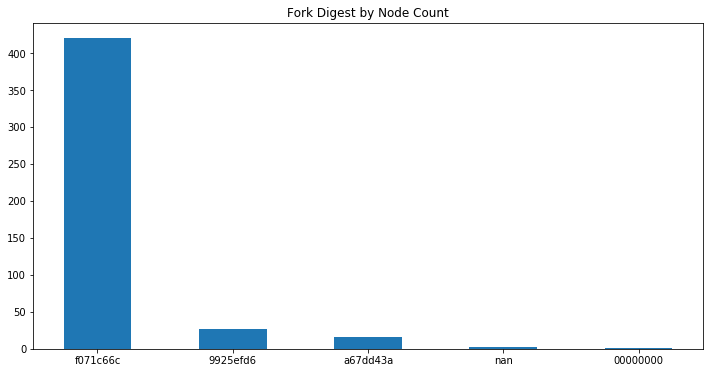

In [71]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt


fork_digests = df_all["fork_digest"].to_list()

counts = Counter(fork_digests)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(12,6))
plt.title('Fork Digest by Node Count')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()


In [72]:
import ipinfo
import pickle

ips = df["ip4"].to_list()

# load any stored ip info
file = open('/Users/jonny/.topaz/ips_info.pkl', 'rb')
saved_ips_info = pickle.load(file)
file.close()

# determine what ips we need to lookup
need_info = []
for ip in ips:
    if ip not in saved_ips_info:
        need_info.append(ip)
        
print("Fetching missing info for ", len(need_info), " ip addresses.");
        
# get missing ip info
handler = ipinfo.getHandler('7bbf8b616179fb')
ips_info = [handler.getDetails(ip) for ip in need_info]

# save the ip info for next time

file = open('/Users/jonny/.topaz/ips_info.pkl', 'wb')

for ip_info in ips_info:
    saved_ips_info[ip_info.ip] = ip_info.all

pickle.dump(saved_ips_info,file)
file.close()


Fetching missing info for  15  ip addresses.


In [73]:
ips_info={}
for ip in ips:
    ips_info[ip]=saved_ips_info[ip]




In [74]:
#WHOIS
# whois -h whois.cymru.com " -v 62.210.170.177"
#  whois -h whois.arin.net 159.65.217.119
# whois -h whois.ripe.net 62.210.170.177
bad_ips = []
for ip,info in ips_info.items():
    if info['country_name'] == None:
        bad_ips.append(ip)
        
pd.set_option('max_colwidth', 100)
#pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 200)
#pd.reset_option('max_colwidth')
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.expand_frame_repr',False)

# collect node_ids of the records with bad ip addresses
bad_ip_node_ids = df[df['ip4'].isin(bad_ips)]['node_id'].to_list()


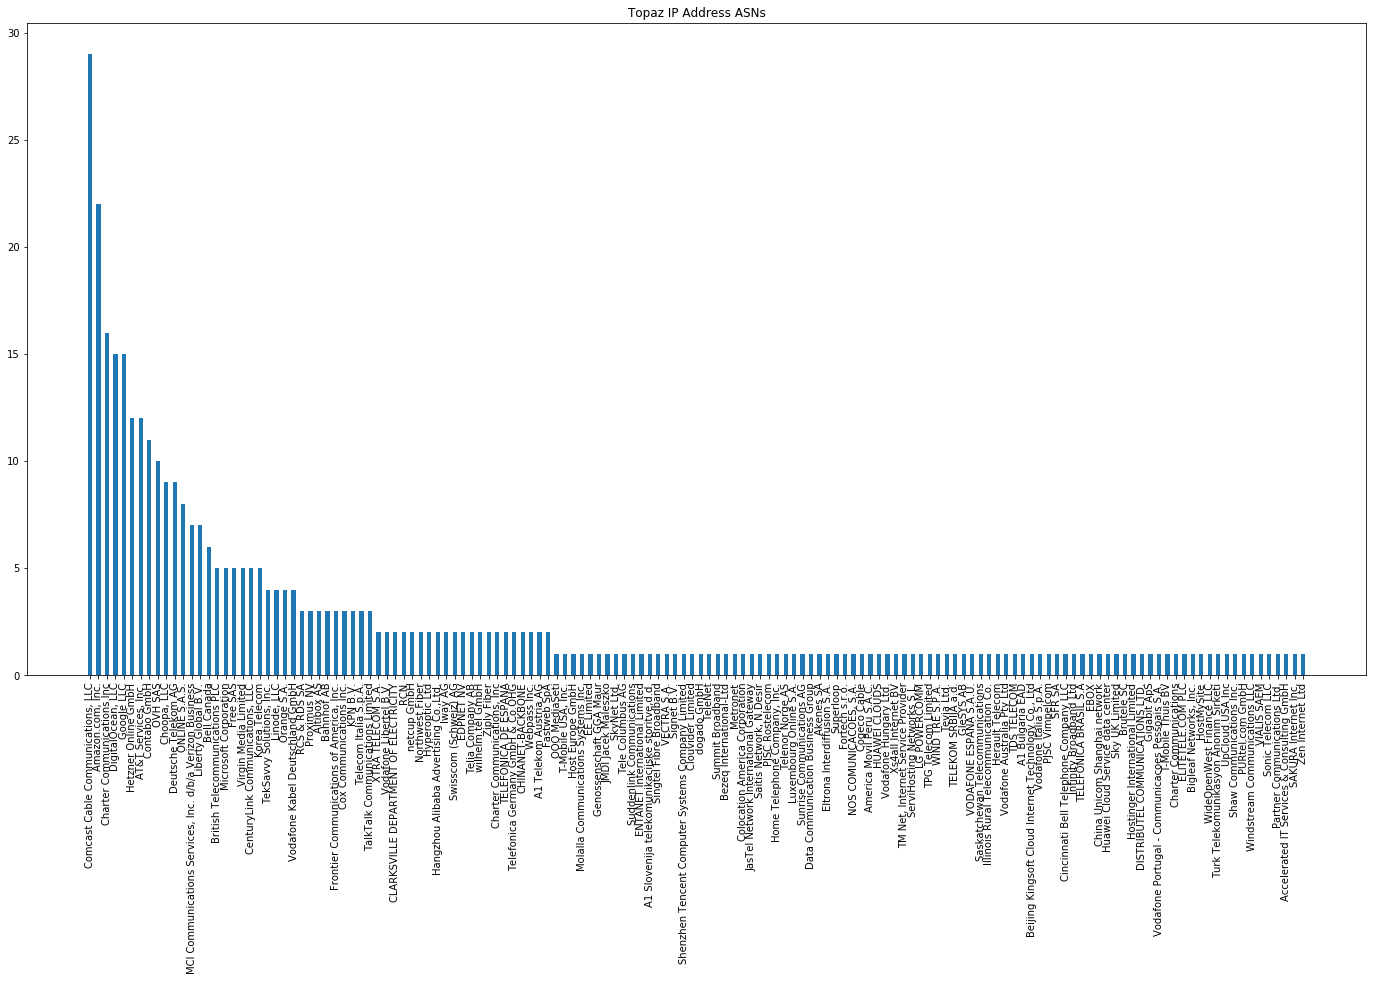

In [75]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

asn_orgs = [info['org'] if 'org' in info else 'None' for ip,info in ips_info.items()]
asn_orgs = [' '.join(org.split(' ')[1:]) for org in asn_orgs if org != 'None']

        
counts = Counter(asn_orgs)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(24,12))
plt.title(NETWORK.title()+' IP Address ASNs')
plt.bar(indexes, values, width)
plt.xticks(rotation=90)
plt.xticks(indexes, labels)
plt.show()


/Users/jonny/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


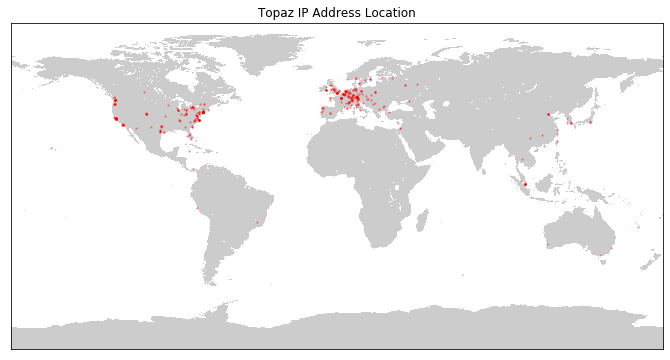

In [76]:
import os
os.environ['PROJ_LIB'] = '/Users/jonny/opt/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lats=[]
lons=[]
for ip,info in ips_info.items():
    if info['country_name'] != None:
        lats.append(float(info['latitude']))
        lons.append(float(info['longitude']))


plt.figure(figsize=(12,6))
map = Basemap(projection='cyl', resolution='l')
#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='#cc9955', lake_color='aqua')
#map.bluemarble()
map.drawlsmask()

x, y = map(lons, lats)
map.scatter(x, y, s=2, color='#ff0000', marker='o', alpha=0.3)
plt.title(NETWORK.title()+' IP Address Location')
plt.show()

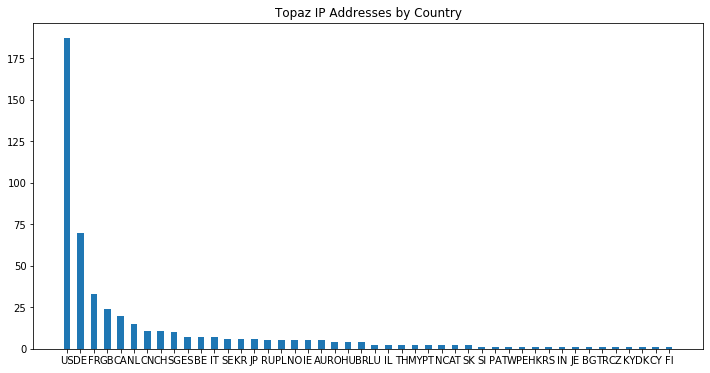

In [77]:
from collections import Counter 
import numpy as np
import matplotlib.pyplot as plt

countries=[]
for ip,info in saved_ips_info.items():
    if info['country_name'] != None:
        countries.append(info['country'])


counts = Counter(countries)
counts = sorted(counts.items(), key=lambda i: i[1], reverse=True)
labels, values  = zip(*counts)

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(12,6))
plt.title(NETWORK.title()+' IP Addresses by Country')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

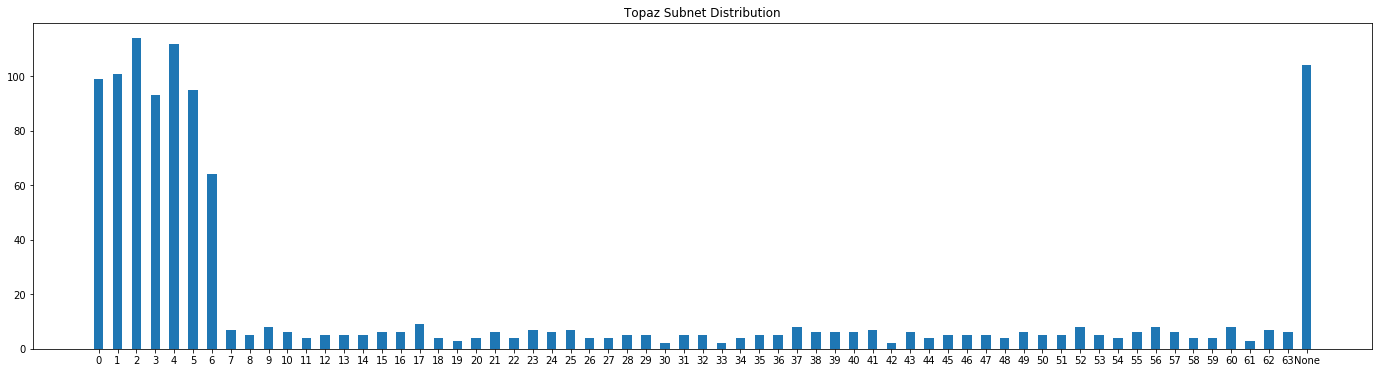

In [78]:
import numpy as np
import matplotlib.pyplot as plt

subnets = df["subnet_ids"].to_list()
subnets = [subnet.replace('[','').replace(']','').replace(' ','') for subnet in subnets]
subnets = [subnet if len(subnet) > 0 else 'None' for subnet in subnets]
subnets = ','.join(subnets)
subnets = subnets.split(',')
labels = [str(label) for label in list(range(0,64))] + ['None']
values = [subnets.count(label) for label in labels]

indexes = np.arange(len(labels))
width = .5
plt.figure(figsize=(24,6))
plt.title(NETWORK.title()+' Subnet Distribution')
plt.bar(indexes, values, width)
plt.xticks(indexes, labels)
plt.show()

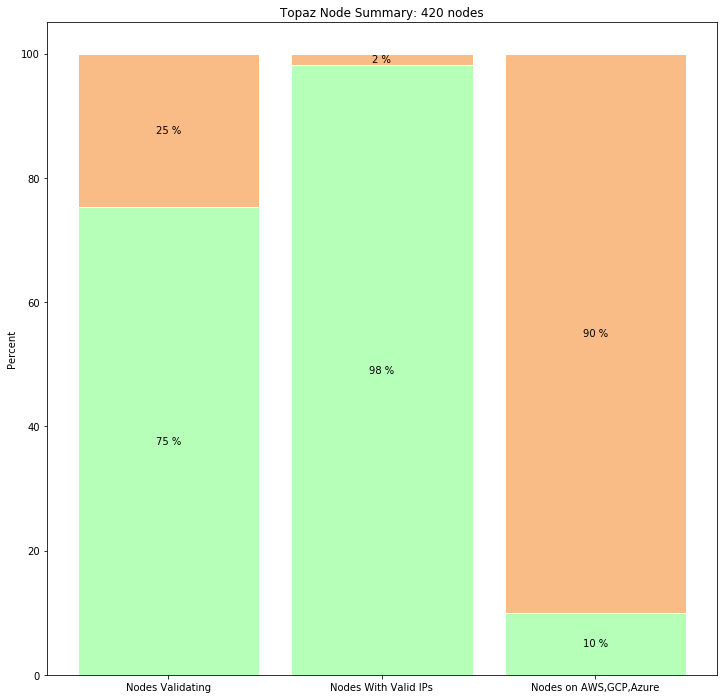

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import Counter 



NUM_NODES = len(df)
df_nodes_with_bad_ip = df_all_with_dups[df_all_with_dups['node_id'].isin(bad_ip_node_ids)].drop_duplicates(subset="node_id", keep = 'first')
PERCENT_WITH_BAD_IP = len(df_nodes_with_bad_ip[df_nodes_with_bad_ip['fork_digest']==FORK_DIGEST])/NUM_NODES
PERCENT_VALIDATING = len(df[df["subnet_ids"]!="[]"])/NUM_NODES
num_nodes_cloud_hosted = 0
for org in asn_orgs:
    if "Amazon"  in org or "Google" in org or "Microsoft" in org:
        num_nodes_cloud_hosted += 1
    
PERCENT_CLOUD_HOSTED=num_nodes_cloud_hosted/NUM_NODES



# Data
r = [0,1,2]
raw_data = {'greenBars': [PERCENT_VALIDATING,1-PERCENT_WITH_BAD_IP,PERCENT_CLOUD_HOSTED], 'orangeBars': [1-PERCENT_VALIDATING,PERCENT_WITH_BAD_IP,1-PERCENT_CLOUD_HOSTED]}
df_nodes = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j for i,j in zip(df_nodes['greenBars'], df_nodes['orangeBars'])]
greenBars = [i / j * 100 for i,j in zip(df_nodes['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df_nodes['orangeBars'], totals)]
 
# plot
barWidth = 0.85
names = ('Nodes Validating','Nodes With Valid IPs','Nodes on AWS,GCP,Azure')
fig,ax = plt.subplots()
# Create green Bars
ax.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
ax.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
ax.set_ylabel('Percent')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.0f} %'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

plt.title(NETWORK.title()+' Node Summary: ' + str(NUM_NODES) + ' nodes')
# Custom x axis
plt.xticks(r, names)

plt.rcParams["figure.figsize"] = (12,12)

# Show graphic
plt.show()



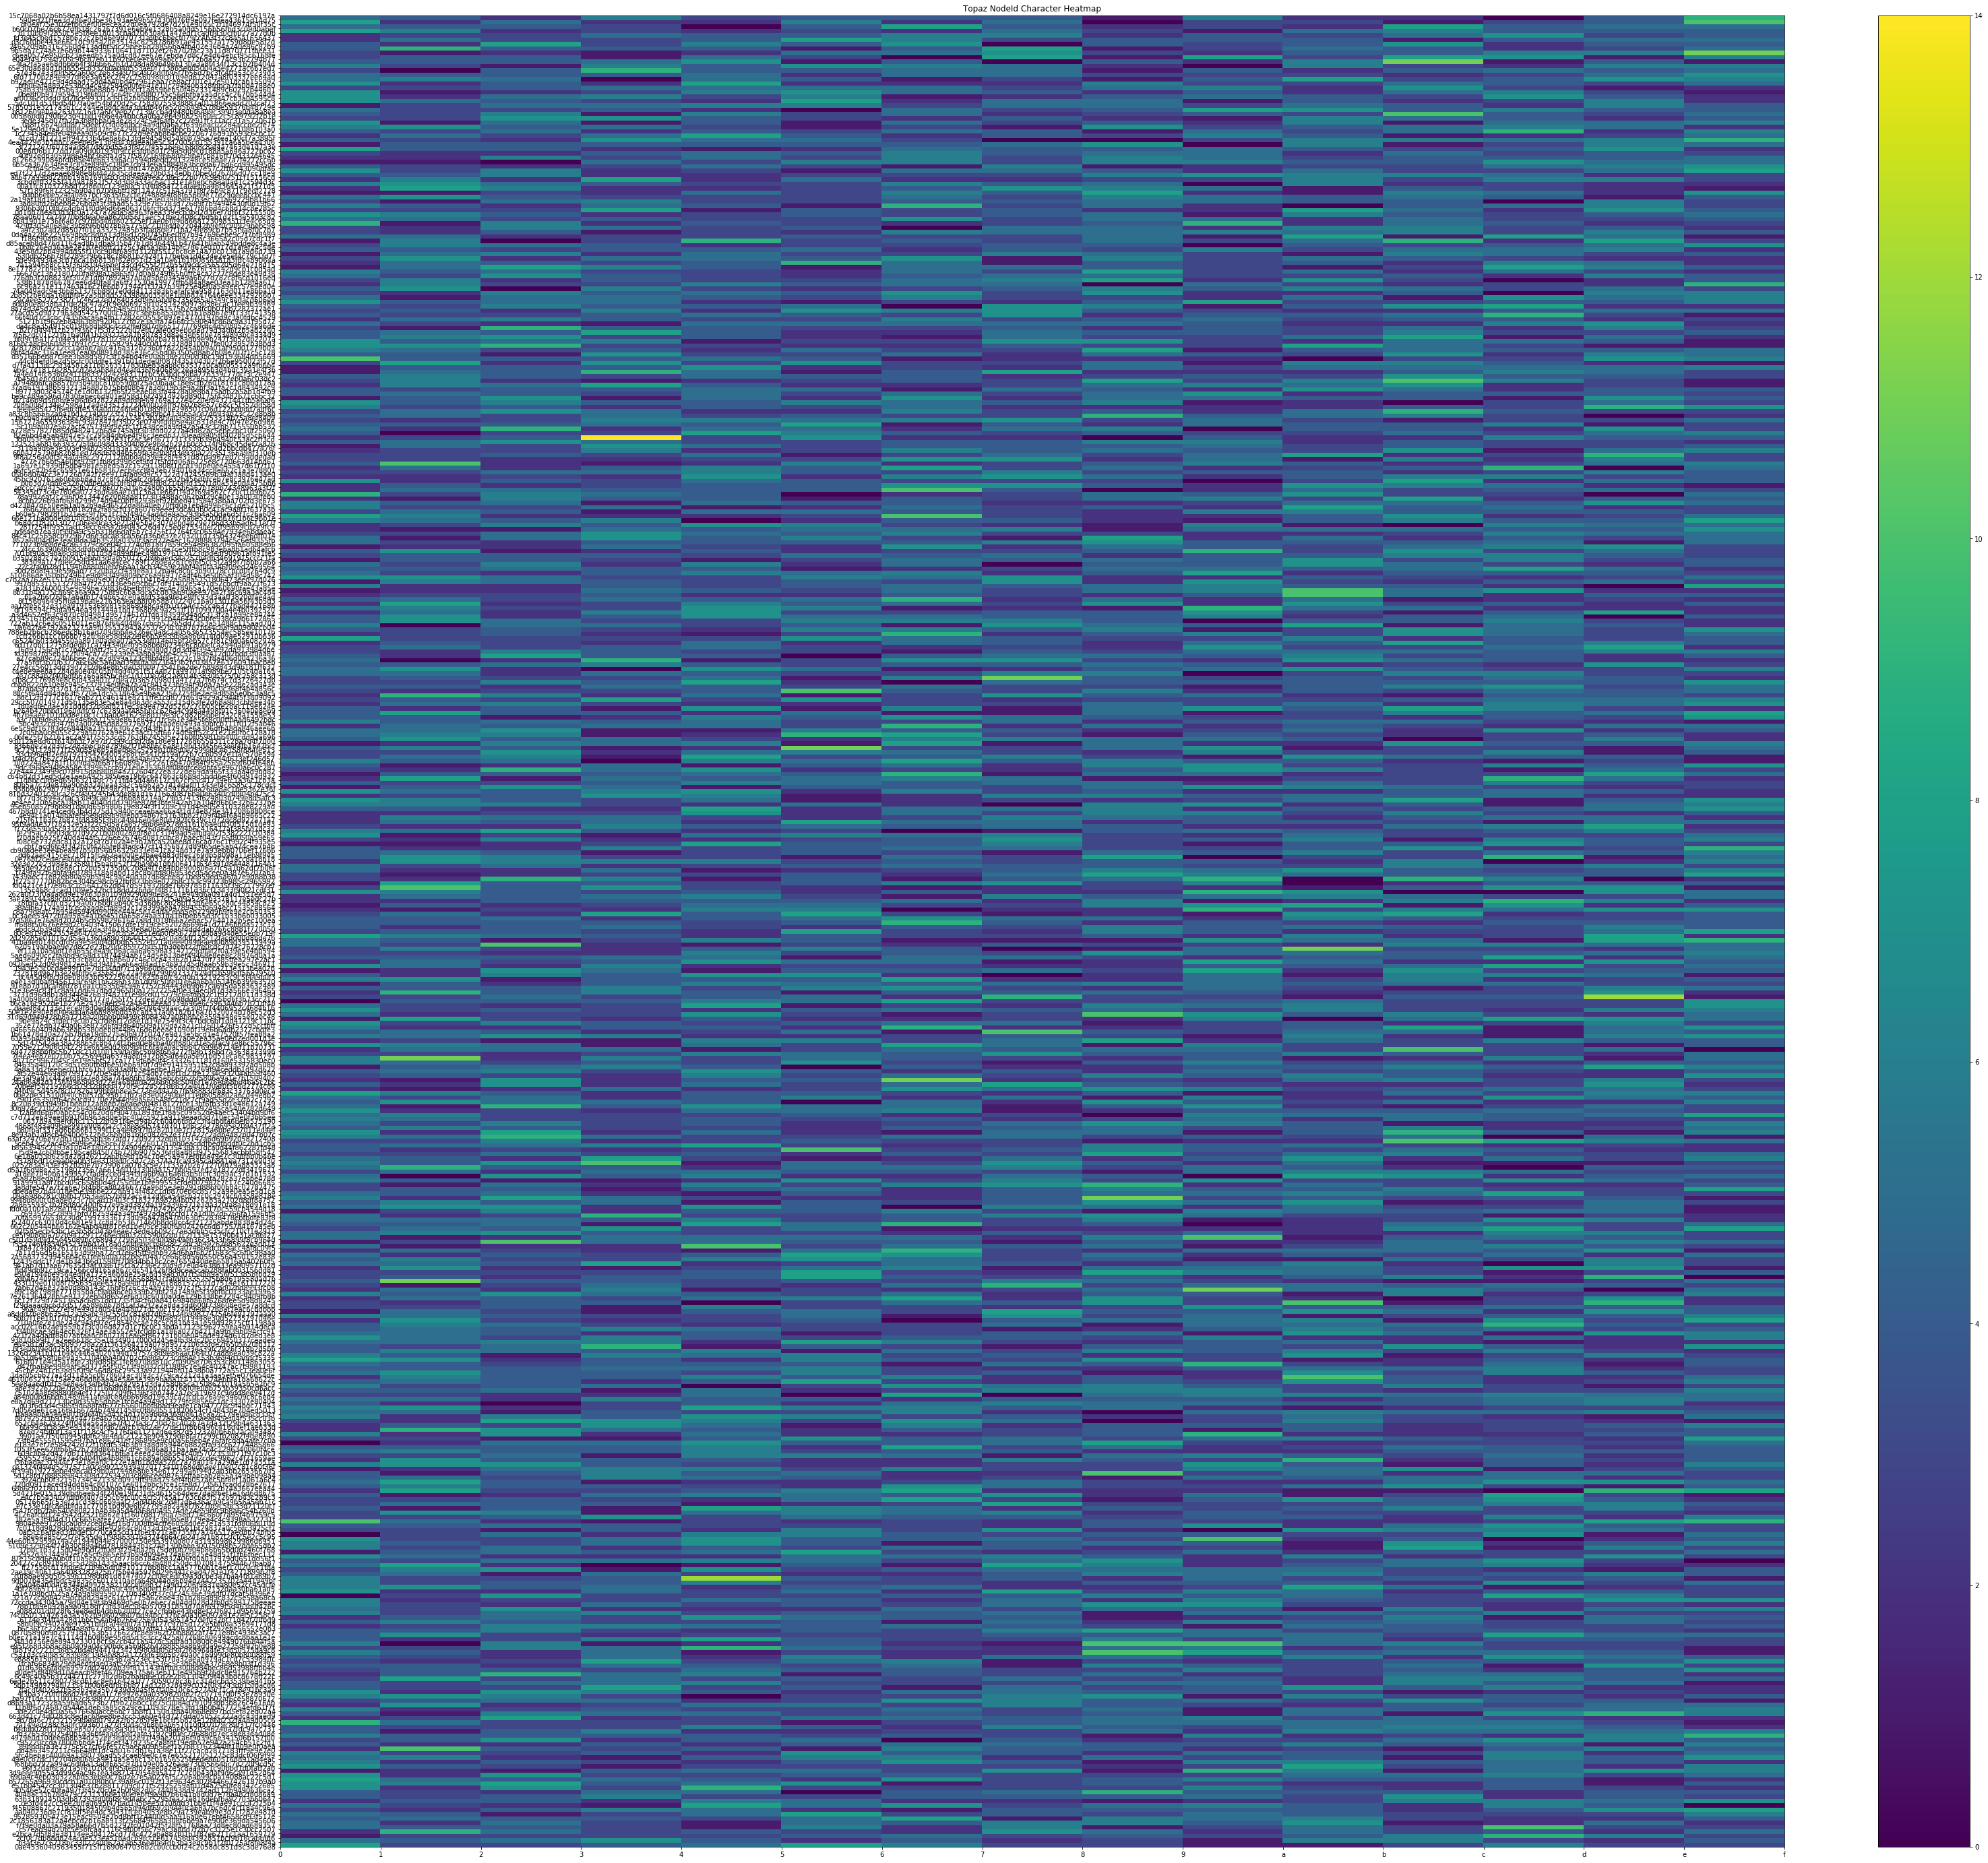

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter 
node_ids = df["node_id"].to_list()
node_ids = [node_id.strip() for node_id in node_ids]
node_ids_freq = [Counter(node_id) for node_id in node_ids]
hex_chars = ['0','1','2','3','4','5','6','7','8','9','a','b','c','d','e','f']
freqs = []
for node_id_freq in node_ids_freq:
    freqs.append([node_id_freq[hex_char] for hex_char in hex_chars])

x, y = np.meshgrid(hex_chars, node_ids)
intensity = np.array(freqs)


plt.title(NETWORK.title()+' NodeId Character Heatmap')
plt.rcParams["figure.figsize"] = (50,50)
plt.pcolormesh(x, y, intensity)
plt.colorbar()
plt.show()

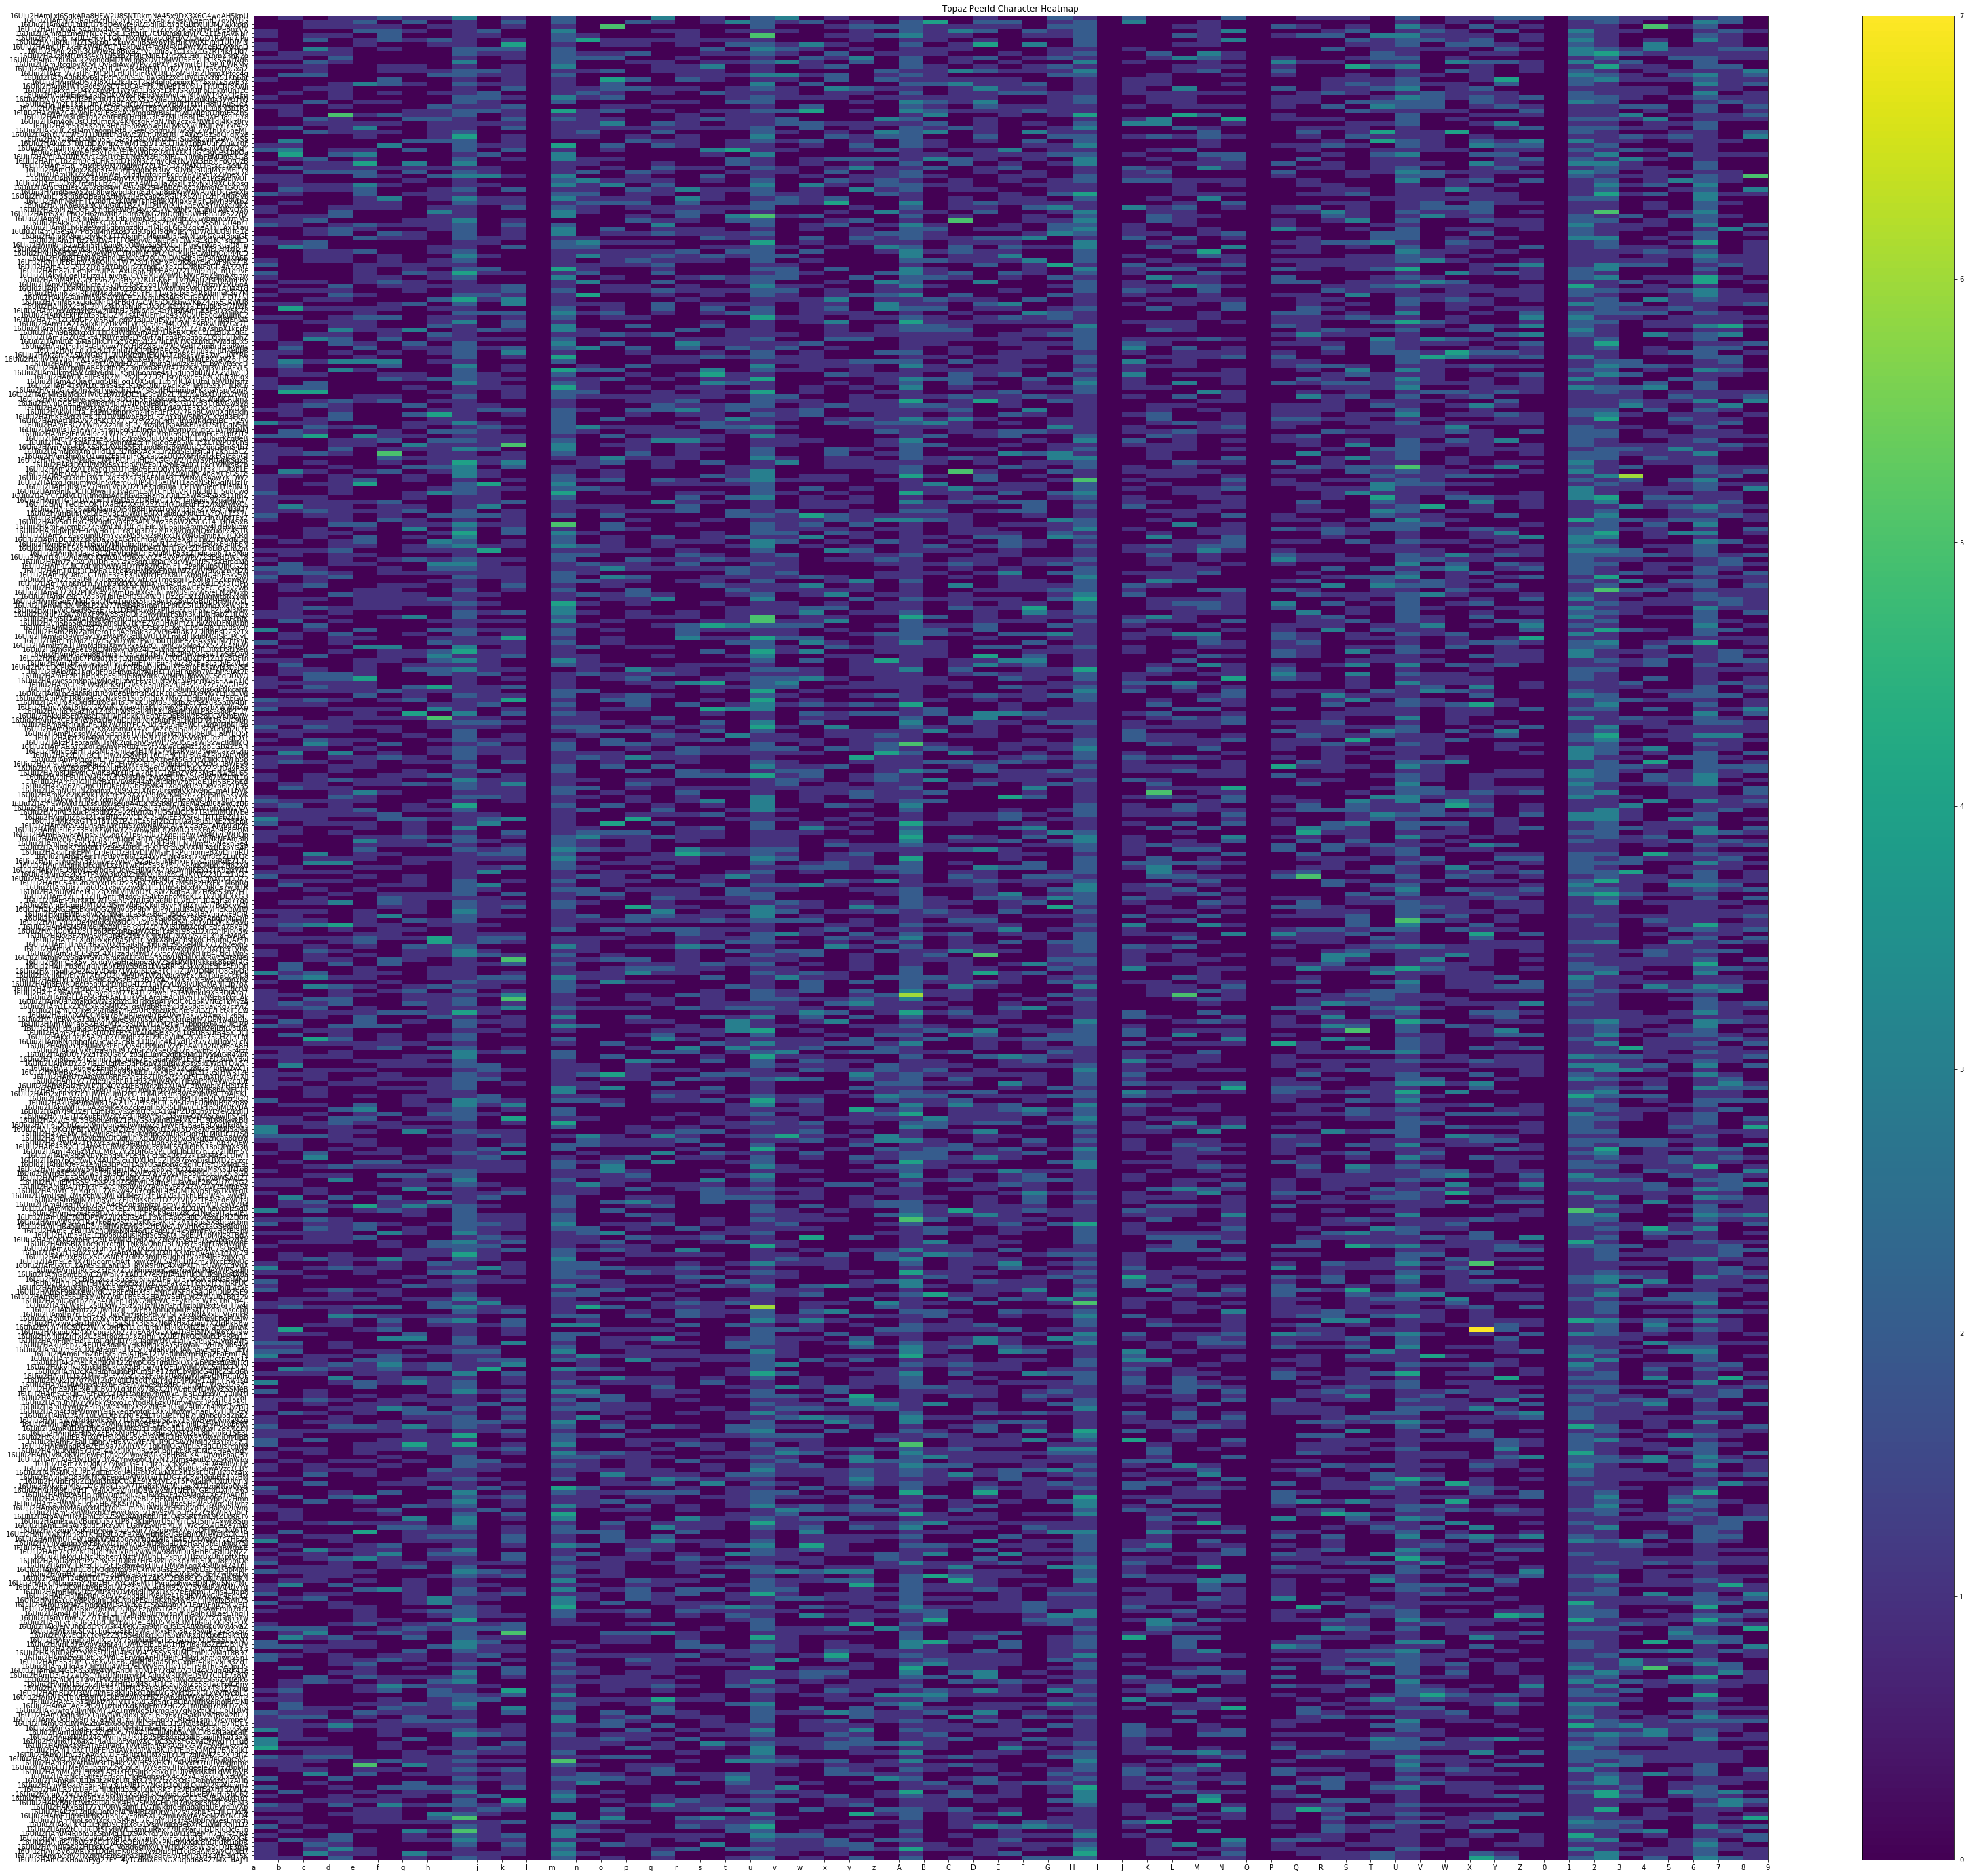

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import string
from collections import Counter 

peer_ids = df["peer_id"].to_list()

peer_ids_freq = [Counter(peer_id) for peer_id in peer_ids]
ascii_chars = [char for char in string.ascii_letters] + ['0','1','2','3','4','5','6','7','8','9']
freqs = []
for peer_id_freq in peer_ids_freq:
    freqs.append([peer_id_freq[char] for char in ascii_chars])

x, y = np.meshgrid(ascii_chars, peer_ids)
intensity = np.array(freqs)


plt.title(NETWORK.title()+' PeerId Character Heatmap')
plt.rcParams["figure.figsize"] = (50,50)
plt.pcolormesh(x, y, intensity)
plt.colorbar() 
plt.show() 